# Banknote Authorization Dataset
[This dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) has various features extracted from a wavelet transformation of an image of a bank note, along with a binary label of whether the sample was fradulent or not.

| variance of wavelet | skewness of wavelet | kurtosis of wavelet | entropy of image | class |
| --- | --- | --- | --- | --- |
| ... | ... | ... | ... | ... |

In [1]:
%matplotlib inline

In [2]:
import pandas as pd 
import numpy as np 
import os 
from sklearn.utils import shuffle 


In [3]:
import matplotlib.pyplot as plt

In [4]:
f = os.listdir()

In [5]:
data_2 = pd.read_csv('data_banknote_authentication.csv')
data_2 = data_2.sample(frac = 1); 
#data = pd.DataFrame()
#data.columns = ["var image", "skew image", "curt image", "entropy image", "class"]

In [6]:
data_2.columns

Index(['Var Image', 'Skew Image', 'Curt Image', 'Entropy Image', 'Class'], dtype='object')

In [7]:
train=data_2.iloc[:int(0.8*len(data_2))]
val=data_2.iloc[int(0.8*len(data_2)):int(0.9*len(data_2))]
test=data_2.iloc[int(0.9*(len(data_2))):]

In [8]:
means=train.mean()[:-1]
stds=train.std()[:-1]

In [9]:
prdctors=train.columns[:-1]

# SGD and Logistic Regression Functions

In [10]:
train[prdctors]=((train[prdctors]-means)/stds)
val[prdctors]=((val[prdctors]-means)/stds)
test[prdctors]=((test[prdctors]-means)/stds)


/home/meltingpot/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return 1.0 / (1.0 + np.exp(-yhat))
def coefficients_sgd(train, l_rate, n_epoch,verbose=False):
    coef = [0.0 for i in range(len(train[0]))]
    errors=[]
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            yhat = predict(row, coef)
            error = row[-1] - yhat
            sum_error += error**2
            coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
        errors.append(sum_error)
        if verbose:
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return coef,errors

# No Regularization

In [12]:
dataset = train.values
l_rate = 0.3
n_epoch = 100
coef,errors = coefficients_sgd(dataset, l_rate, n_epoch,verbose=True)
print(coef)

>epoch=0, lrate=0.300, error=54.141
>epoch=1, lrate=0.300, error=23.150
>epoch=2, lrate=0.300, error=18.917
>epoch=3, lrate=0.300, error=16.901
>epoch=4, lrate=0.300, error=15.657
>epoch=5, lrate=0.300, error=14.789
>epoch=6, lrate=0.300, error=14.137
>epoch=7, lrate=0.300, error=13.625
>epoch=8, lrate=0.300, error=13.207
>epoch=9, lrate=0.300, error=12.858
>epoch=10, lrate=0.300, error=12.560
>epoch=11, lrate=0.300, error=12.302
>epoch=12, lrate=0.300, error=12.075
>epoch=13, lrate=0.300, error=11.874
>epoch=14, lrate=0.300, error=11.694
>epoch=15, lrate=0.300, error=11.531
>epoch=16, lrate=0.300, error=11.383
>epoch=17, lrate=0.300, error=11.247
>epoch=18, lrate=0.300, error=11.123
>epoch=19, lrate=0.300, error=11.008
>epoch=20, lrate=0.300, error=10.901
>epoch=21, lrate=0.300, error=10.801
>epoch=22, lrate=0.300, error=10.709
>epoch=23, lrate=0.300, error=10.622
>epoch=24, lrate=0.300, error=10.540
>epoch=25, lrate=0.300, error=10.463
>epoch=26, lrate=0.300, error=10.390
>epoch=27, 

Text(0,0.5,'Error')

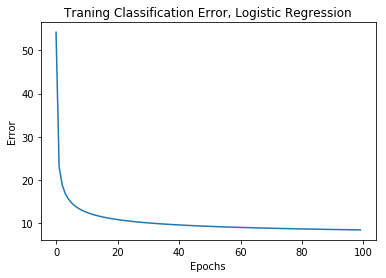

In [31]:
plt.plot(errors)
plt.title("Traning Classification Error, Logistic Regression")
plt.xlabel("Epochs")
plt.ylabel("Error")

![title](img/confusion_matrix2.png)

In [14]:
conf_matrix=pd.DataFrame(np.zeros((2,2)),columns=[0,1],index=[0,1])
for i in val.values:
    conf_matrix.loc[i[-1],round(predict(i,coef))]+=1

In [15]:
conf_matrix.columns=["predict_0","predict_1"]
conf_matrix.index=["actual_0","actual_1"]

In [16]:
conf_matrix

,predict_0,predict_1
actual_0,73.0,2.0
actual_1,0.0,62.0


In [17]:
acc=np.diag(conf_matrix.values).sum()/conf_matrix.values.sum()

In [18]:
acc

0.98540145985401462

# L2 Reg

In [32]:
def coefficients_sgd_l2(train, l_rate, n_epoch,lambd,verbose=False):
    coef=np.zeros(len(train[0]))
    errors=[]
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            yhat = predict(row, coef)
            error = row[-1] - yhat
            sum_error += error**2
            coef[0] = coef[0] + l_rate *(-lambd*coef[0]+ error * yhat * (1.0 - yhat))
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] + l_rate *(-lambd*coef[i+1] + error * yhat * (1.0 - yhat) * row[i])
        errors.append(sum_error)
        if verbose:
            print('>epoch=%d, lrate=%.4f, error=%.3f' % (epoch, l_rate, sum_error))
    return coef,errors

In [48]:
dataset = train.values
l_rate = 0.0001
n_epoch = 1000


coef,errors_ridge = coefficients_sgd_l2(dataset, l_rate, n_epoch,0.1,verbose=False)

Text(0,0.5,'Error')

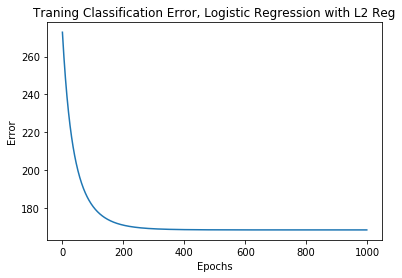

In [49]:
plt.plot(errors_ridge)
plt.title("Traning Classification Error, Logistic Regression with L2 Reg")
plt.xlabel("Epochs")
plt.ylabel("Error")

In [50]:
conf_matrix=pd.DataFrame(np.zeros((2,2)),columns=[0,1],index=[0,1])
for i in val.values:
    conf_matrix.loc[i[-1],round(predict(i,coef))]+=1

In [51]:
conf_matrix.columns=["predict_0","predict_1"]
conf_matrix.index=["actual_0","actual_1"]

In [52]:
conf_matrix

,predict_0,predict_1
actual_0,70.0,5.0
actual_1,10.0,52.0


In [53]:
acc=np.diag(conf_matrix.values).sum()/conf_matrix.values.sum()
acc

0.89051094890510951

## Scale

In [65]:
lambdas=np.logspace(start=-2.5,stop=0.085)
lambdas=lambdas[lambdas<1]

In [66]:
lambdas

array([ 0.00316228,  0.00357071,  0.0040319 ,  0.00455266,  0.00514068,
        0.00580464,  0.00655436,  0.00740092,  0.00835682,  0.00943617,
        0.01065494,  0.01203112,  0.01358505,  0.01533968,  0.01732094,
        0.01955809,  0.0220842 ,  0.02493657,  0.02815735,  0.03179413,
        0.03590063,  0.04053752,  0.0457733 ,  0.05168534,  0.05836096,
        0.06589881,  0.07441023,  0.08402098,  0.09487305,  0.10712676,
        0.12096314,  0.13658662,  0.15422801,  0.17414795,  0.19664073,
        0.22203865,  0.25071694,  0.28309929,  0.31966411,  0.36095161,
        0.40757176,  0.46021332,  0.51965401,  0.58677201,  0.6625589 ,
        0.74813434,  0.84476263,  0.95387133])

In [70]:
accs=pd.DataFrame(index=lambdas,columns=["acc"])
coefs=[]
for j in lambdas:
    coef,_ = coefficients_sgd_l2(dataset, l_rate, 500,j)
    coefs.append(coef)
    conf_matrix=pd.DataFrame(np.zeros((2,2)),columns=[0,1],index=[0,1])
    for i in val.values:
        conf_matrix.loc[i[-1],round(predict(i,coef))]+=1
    acc=np.diag(conf_matrix.values).sum()/conf_matrix.values.sum()
    accs.loc[j,"acc"]=acc

Text(0,0.5,'Val Acc')

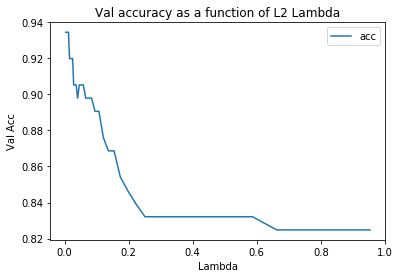

In [82]:
accs.plot()
plt.title("Val accuracy as a function of L2 Lambda")
plt.xlabel("Lambda")
plt.ylabel("Val Acc")

# Out of Sample Comparison

In [75]:
ridge_coef=coefs[0]
normal_coef,errors = coefficients_sgd(dataset, l_rate, n_epoch,verbose=False)


In [76]:
ridge_conf_matrix=pd.DataFrame(np.zeros((2,2)),columns=[0,1],index=[0,1])
for i in test.values:
    ridge_conf_matrix.loc[i[-1],round(predict(i,ridge_coef))]+=1

In [77]:
ridge_conf_matrix

,0,1
0,71.0,3.0
1,4.0,60.0


In [78]:
np.diag(ridge_conf_matrix.values).sum()/ridge_conf_matrix.values.sum()

0.94927536231884058

In [79]:
norm_conf_matrix=pd.DataFrame(np.zeros((2,2)),columns=[0,1],index=[0,1])
for i in test.values:
    norm_conf_matrix.loc[i[-1],round(predict(i,normal_coef))]+=1

In [80]:
norm_conf_matrix

,0,1
0,72.0,2.0
1,2.0,62.0


In [81]:
np.diag(norm_conf_matrix.values).sum()/norm_conf_matrix.values.sum()

0.97101449275362317

Normal Logistic Regression accuracy is higher.